In [1]:
# Hypothesis:  The 5-dimensional OCEAN data set can be represented in 3 dimensions visualized by 27 clusters of points in a 3x3x3 cube.
# Experiment:  Apply machine learning tools that use a dimensionality reduction technique like Principal Component Analysis (PCA) to the Kaggle OCEAN data set. Python provides several machine learning libraries that offer implementations of these dimensionality reduction techniques, such as scikit-learn, TensorFlow, and PyTorch. You can leverage these libraries to apply dimensionality reduction to a 5-dimensional dataset and visualize it in a 3-dimensional space.
# Data set:  https://1drv.ms/u/s!Aj7B9GbKP2y3icRAAZT8i8hNRDq5Vg?e=tMAh8W
# (Reference: https://www.kaggle.com/datasets/tunguz/big-five-personality-test )

In [187]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns

pd.options.plotting.backend = "plotly"

import matplotlib.pyplot as plt

## Preprocessing / EDA / Data Cleaning

In [3]:
df = pd.read_csv("data/data-subset.csv", sep="\t")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Columns: 110 entries, EXT1 to long_appx_lots_of_err
dtypes: float64(104), int64(2), object(4)
memory usage: 8.4+ MB


In [4]:
# first 50 columns are the columns of interest
df.columns[:50]

Index(['EXT1', 'EXT2', 'EXT3', 'EXT4', 'EXT5', 'EXT6', 'EXT7', 'EXT8', 'EXT9',
       'EXT10', 'EST1', 'EST2', 'EST3', 'EST4', 'EST5', 'EST6', 'EST7', 'EST8',
       'EST9', 'EST10', 'AGR1', 'AGR2', 'AGR3', 'AGR4', 'AGR5', 'AGR6', 'AGR7',
       'AGR8', 'AGR9', 'AGR10', 'CSN1', 'CSN2', 'CSN3', 'CSN4', 'CSN5', 'CSN6',
       'CSN7', 'CSN8', 'CSN9', 'CSN10', 'OPN1', 'OPN2', 'OPN3', 'OPN4', 'OPN5',
       'OPN6', 'OPN7', 'OPN8', 'OPN9', 'OPN10'],
      dtype='object')

In [15]:
df_sub = df[df.columns[:50]]
df_sub.head()
df_sub.shape

(10000, 50)

In [28]:
# There are 0 values that need to be dealt with
# The data range is 1-5, which means 0 values should be treated as missing
df_sub = df_sub.replace(0, np.NaN)
df_sub = df_sub.dropna()
df_sub.shape
# df_sub = df_sub.dropna()

(8578, 50)

In [29]:
df_sub.loc[0] = [4, 1, 5, 2, 5, 1, 5, 2, 4, 1, 1, 4, 4, 2, 2, 2, 2, 2, 3, 2, 2, 5, 2, 4, 2, 3, 2, 4, 3, 4, 3, 4, 3, 2, 2, 4, 4, 2, 4, 4, 5, 1, 4, 1, 4, 1, 5, 3, 4, 5]
df_sub.loc[1] = [3, 5, 3, 4, 3, 3, 2, 5, 1, 5, 2, 3, 4, 1, 3, 1, 2, 1, 3, 1, 1, 4, 1, 5, 1, 5, 3, 4, 5, 3, 3, 2, 5, 3, 3, 1, 3, 3, 5, 3, 1, 2, 4, 2, 3, 1, 4, 2, 5, 3]
df_sub.shape
# df_sub.tail()

(8578, 50)

In [30]:
# Normalizing data points between -1 & 1
# We want 1 -> -1, 3-> 0, & 5 -> 1
df_norm = (df_sub - 3) / 2 # assuming mean is 3 and range is 1-5
df_norm.shape
# df_norm.tail()

(8578, 50)

In [31]:
"""
Polarity of answers

+ EXT1", "I am the life of the party.
- EXT2", "I don't talk a lot.
+ EXT3", "I feel comfortable around people.
- EXT4", "I keep in the background.
+ EXT5", "I start conversations.
- EXT6", "I have little to say.
+ EXT7", "I talk to a lot of different people at parties.
- EXT8", "I don't like to draw attention to myself.
+ EXT9", "I don't mind being the center of attention.
- EXT10", "I am quiet around strangers.

+ EST1", "I get stressed out easily.
- EST2", "I am relaxed most of the time.
+ EST3", "I worry about things.
- EST4", "I seldom feel blue.
+ EST5", "I am easily disturbed.
+ EST6", "I get upset easily.
+ EST7", "I change my mood a lot.
+ EST8", "I have frequent mood swings.
+ EST9", "I get irritated easily.
+ EST10", "I often feel blue.

- AGR1", "I feel little concern for others.
+ AGR2", "I am interested in people.
- AGR3", "I insult people.
+ AGR4", "I sympathize with others' feelings.
- AGR5", "I am not interested in other people's problems.
+ AGR6", "I have a soft heart.
- AGR7", "I am not really interested in others.
+ AGR8", "I take time out for others.
+ AGR9", "I feel others' emotions.
+ AGR10", "I make people feel at ease.

+ CSN1", "I am always prepared.
- CSN2", "I leave my belongings around.
+ CSN3", "I pay attention to details.
- CSN4", "I make a mess of things.
+ CSN5", "I get chores done right away.
- CSN6", "I often forget to put things back in their proper place.
+ CSN7", "I like order.
- CSN8", "I shirk my duties.
+ CSN9", "I follow a schedule.
+ CSN10", "I am exacting in my work.

+ OPN1", "I have a rich vocabulary.
- OPN2", "I have difficulty understanding abstract ideas.
+ OPN3", "I have a vivid imagination.
- OPN4", "I am not interested in abstract ideas.
+ OPN5", "I have excellent ideas.
- OPN6", "I do not have a good imagination.
+ OPN7", "I am quick to understand things.
+ OPN8", "I use difficult words.
+ OPN9", "I spend time reflecting on things.
+ OPN10", "I am full of ideas.
"""

polarity_dict = {
    "EXT1": 1,
    "EXT2": -1,
    "EXT3": 1,
    "EXT4": -1,
    "EXT5": 1,
    "EXT6": -1,
    "EXT7": 1,
    "EXT8": -1,
    "EXT9": 1,
    "EXT10": -1,
    
    "EST1": 1,
    "EST2": -1,
    "EST3": 1,
    "EST4": -1,
    "EST5": 1,
    "EST6": 1,
    "EST7": 1,
    "EST8": 1,
    "EST9": 1,
    "EST10": 1,
    
    "AGR1": -1,
    "AGR2": 1,
    "AGR3": -1,
    "AGR4": 1,
    "AGR5": -1,
    "AGR6": 1,
    "AGR7": -1,
    "AGR8": 1,
    "AGR9": 1,
    "AGR10": 1,
    
    "CSN1": 1,
    "CSN2": -1,
    "CSN3": 1,
    "CSN4": -1,
    "CSN5": 1,
    "CSN6": -1,
    "CSN7": 1,
    "CSN8": -1,
    "CSN9": 1,
    "CSN10": 1,
    
    "OPN1": 1,
    "OPN2": -1,
    "OPN3": 1,
    "OPN4": -1,
    "OPN5": 1,
    "OPN6": -1,
    "OPN7": 1,
    "OPN8": 1,
    "OPN9": 1,
    "OPN10": 1,
}


In [32]:
# accounting for polarity
df_cp = df_norm.copy()
for col in df_norm.columns:
    df_cp[col] = df_norm[col] * polarity_dict[col]
df_cp.head()

,EXT1,EXT2,EXT3,EXT4,EXT5,EXT6,EXT7,EXT8,EXT9,EXT10,...,OPN1,OPN2,OPN3,OPN4,OPN5,OPN6,OPN7,OPN8,OPN9,OPN10
0,0.5,1.0,1.0,0.5,1.0,1.0,1.0,0.5,0.5,1.0,...,1.0,1.0,0.5,1.0,0.5,1.0,1.0,0.0,0.5,1.0
3,-1.0,-0.0,0.0,-0.5,0.5,-0.0,-0.5,-1.0,-1.0,-1.0,...,0.5,-0.0,0.5,0.5,0.0,0.5,0.0,0.0,0.0,0.5
4,-0.5,1.0,0.5,0.5,0.5,0.5,0.5,-0.0,-0.5,-0.5,...,0.5,1.0,1.0,1.0,1.0,1.0,1.0,-0.5,0.5,0.5
5,0.0,0.5,0.5,-0.0,0.5,0.5,0.0,-0.0,0.0,-0.5,...,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.0,0.5,0.5
6,0.5,0.5,0.5,-0.0,1.0,0.5,0.5,-0.0,0.5,0.5,...,0.5,0.5,-0.5,-0.5,0.5,-0.5,1.0,-0.5,0.5,0.5


In [33]:
df_T = df_cp.T
df_T["type"] = df_T.index.str.slice(0,3)
df_E = df_T.groupby("type", sort=False).sum().T
# NOTE: Mean is taken ignoring np.NaN values. 
# Effectively does the same thing as conditional mean imputation
df_E.head()

type,EXT,EST,AGR,CSN,OPN
0,8.0,-3.0,4.5,1.0,7.5
3,-4.5,3.5,2.0,-3.5,2.5
4,2.0,2.5,8.0,-1.0,7.0
5,1.5,0.5,4.5,2.5,4.5
6,4.5,-4.0,-4.0,4.5,1.5


In [36]:
# print(df_E.isna().sum())
# Still some nan values
# Means that within certain responses, all values were missing for a trait
df_ED = df_E.dropna(axis=0)

In [37]:
df_ED.describe()
print(df_ED.describe().to_markdown())

|       |         EXT |         EST |        AGR |        CSN |        OPN |
|:------|------------:|------------:|-----------:|-----------:|-----------:|
| count | 8578        | 8578        | 8578       | 8578       | 8578       |
| mean  |   -0.163441 |    0.282234 |    3.8713  |    1.83697 |    4.4121  |
| std   |    4.57089  |    4.31566  |    3.63764 |    3.69272 |    3.19749 |
| min   |  -10        |  -10        |  -10       |  -10       |   -9.5     |
| 25%   |   -3.5      |   -3        |    1.5     |   -0.5     |    2       |
| 50%   |    0        |    0.5      |    4.5     |    2       |    4.5     |
| 75%   |    3        |    3.5      |    6.5     |    4.5     |    7       |
| max   |   10        |   10        |   10       |   10       |   10       |


In [39]:
# Normalization
df_EDN = (df_ED - df_ED.mean()) / df_ED.std()
df_EDN.cov()
print(df_EDN.cov().to_markdown())

| type   |        EXT |        EST |        AGR |        CSN |        OPN |
|:-------|-----------:|-----------:|-----------:|-----------:|-----------:|
| EXT    |  1         | -0.207867  |  0.30701   |  0.0422316 |  0.149488  |
| EST    | -0.207867  |  1         | -0.0513682 | -0.217699  | -0.0848977 |
| AGR    |  0.30701   | -0.0513682 |  1         |  0.154067  |  0.10737   |
| CSN    |  0.0422316 | -0.217699  |  0.154067  |  1         |  0.0609256 |
| OPN    |  0.149488  | -0.0848977 |  0.10737   |  0.0609256 |  1         |


## PCA

In [40]:
pca = PCA(n_components=3) # 3 principal components
pca_data = pca.fit_transform(df_EDN)
pca_df = pd.DataFrame(pca_data, columns=["PC1", "PC2", "PC3"])

In [41]:
pd.DataFrame(index=["PC1", "PC2", "PC3"], data={"Proportion of Variance Explained": pca.explained_variance_ratio_, "Cumulative Proportion": np.cumsum(pca.explained_variance_ratio_)})
print(pd.DataFrame(index=["PC1", "PC2", "PC3"], data={"Proportion of Variance Explained": pca.explained_variance_ratio_, "Cumulative Proportion": np.cumsum(pca.explained_variance_ratio_)}).to_markdown())

|     |   Proportion of Variance Explained |   Cumulative Proportion |
|:----|-----------------------------------:|------------------------:|
| PC1 |                           0.31423  |                0.31423  |
| PC2 |                           0.208306 |                0.522536 |
| PC3 |                           0.184696 |                0.707233 |


In [42]:
pd.DataFrame(index=["PC1", "PC2", "PC3"], data=pca.components_, columns=df_EDN.columns)
print(pd.DataFrame(index=["PC1", "PC2", "PC3"], data=pca.components_, columns=df_EDN.columns).to_markdown())

|     |       EXT |      EST |       AGR |       CSN |       OPN |
|:----|----------:|---------:|----------:|----------:|----------:|
| PC1 | -0.545612 | 0.43871  | -0.499246 | -0.378743 | -0.342269 |
| PC2 |  0.363516 | 0.519987 |  0.363115 | -0.632158 |  0.256893 |
| PC3 |  0.122975 | 0.185849 |  0.479146 |  0.159992 | -0.833762 |


In [18]:
fig = px.scatter_3d(pca_df.sample(250), x='PC1', y='PC2', z='PC3')
fig.show()

# Hypothesis:  The 5-dimensional OCEAN data set can be represented in 3 dimensions visualized by 27 clusters of points in a 3x3x3 cube.

In [19]:
# fig.write_html("pca-e-250.html")

## Clustering


In [132]:
# This is the dataframe that's going to be used for clustering
df_ED_full = df_ED.copy()
df_ED_small = df_ED.sample(1000, random_state=0)

print(df_ED_full.shape, df_ED_small.shape)

(8578, 5) (1000, 5)


In [133]:
from sklearn.cluster import KMeans, AffinityPropagation, MeanShift, SpectralClustering, AgglomerativeClustering, DBSCAN, OPTICS, Birch
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

In [134]:
clustering_metrics = pd.DataFrame(columns=["num clusters", "sse (inertia)", "silhouette", "davies_bouldin", "calinski_harabasz"])

In [135]:
for i in range(26):
    k = i + 2
    kmeans = KMeans(n_clusters=k, random_state=0).fit(df_ED_small)
    clustering_metrics.loc[f"KMeans (k={k})"] = [
        k,
        kmeans.inertia_, 
        silhouette_score(df_ED_small, kmeans.labels_), 
        davies_bouldin_score(df_ED_small, kmeans.labels_), 
        calinski_harabasz_score(df_ED_small, kmeans.labels_)
    ]

In [136]:
# quadratic time complexity O(N^2)
# over a hundred clusters found

affinity = AffinityPropagation(random_state=0).fit(df_ED_small)

clustering_metrics.loc["AffinityPropagation"] = [
    len(affinity.cluster_centers_indices_),
    np.NaN,
    silhouette_score(df_ED_small, affinity.labels_), 
    davies_bouldin_score(df_ED_small, affinity.labels_), 
    calinski_harabasz_score(df_ED_small, affinity.labels_)
]

In [137]:
# quadratic time complexity
# interesting to note that it found only one cluster
# silhouette davies and calinski require the existence of another cluster in order to work

mean_shift = MeanShift().fit(df_ED_small)
clustering_metrics.loc["MeanShift"] = [
    len(mean_shift.cluster_centers_),
    np.NaN, np.NaN, np.NaN, np.NaN
    # silhouette_score(df_ED_small, mean_shift.labels_), 
    # davies_bouldin_score(df_ED_small, mean_shift.labels_), 
    # calinski_harabasz_score(df_ED_small, mean_shift.labels_)
]

In [138]:
# quadratic O(n^3)

spectral = SpectralClustering().fit(df_ED_small)

/Users/elim-mbp-01/.pyenv/versions/3.8.16/envs/dsc80_39/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:369: UserWarning: Exited at iteration 2000 with accuracies 
[6.71179877e-13 1.90052455e-06 5.75135254e-07 3.13735508e-06
 2.73078559e-06 7.60918446e-07 7.86879697e-06 1.01159452e-06
 7.09982959e-07]
not reaching the requested tolerance 1e-15.
Use iteration 1998 instead with accuracy 
1.991153566065182e-06.

  _, diffusion_map = lobpcg(
/Users/elim-mbp-01/.pyenv/versions/3.8.16/envs/dsc80_39/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:369: UserWarning: Exited postprocessing with accuracies 
[7.18819339e-13 1.76818721e-06 6.13363872e-07 2.90608941e-06
 2.55784311e-06 7.05969193e-07 7.59702694e-06 9.94885254e-07
 7.61500621e-07]
not reaching the requested tolerance 1e-15.
  _, diffusion_map = lobpcg(


In [139]:
clustering_metrics.loc["SpectralClustering"] = [
    len(np.unique(spectral.labels_)),
    np.NaN,
    silhouette_score(df_ED_small, spectral.labels_),
    davies_bouldin_score(df_ED_small, spectral.labels_),
    calinski_harabasz_score(df_ED_small, spectral.labels_)
]

In [140]:
agglomerative = AgglomerativeClustering().fit(df_ED_small)
clustering_metrics.loc["AgglomerativeClustering"] = [
    len(np.unique(agglomerative.labels_)),
    np.NaN,
    silhouette_score(df_ED_small, agglomerative.labels_),
    davies_bouldin_score(df_ED_small, agglomerative.labels_),
    calinski_harabasz_score(df_ED_small, agglomerative.labels_)
]

In [141]:
# only one cluster found
dbscan = DBSCAN().fit(df_ED_small)
clustering_metrics.loc["DBSCAN"] = [
    len(np.unique(dbscan.labels_)),
    np.NaN, np.NaN, np.NaN, np.NaN
    # silhouette_score(df_ED_small, dbscan.labels_),
    # davies_bouldin_score(df_ED_small, dbscan.labels_),
    # calinski_harabasz_score(df_ED_small, dbscan.labels_)
]

In [142]:
# negative silhouette score for optics
# disimillar to own cluster, more similar to other

optics = OPTICS().fit(df_ED_small)
clustering_metrics.loc["OPTICS"] = [
    len(np.unique(optics.labels_)),
    np.NaN,
    np.NaN if len(np.unique(optics.labels_)) == 1 else silhouette_score(df_ED_small, optics.labels_),
    np.NaN if len(np.unique(optics.labels_)) == 1 else davies_bouldin_score(df_ED_small, optics.labels_),
    np.NaN if len(np.unique(optics.labels_)) == 1 else calinski_harabasz_score(df_ED_small, optics.labels_)
]
    

In [143]:
birch = Birch().fit(df_ED_small)
clustering_metrics.loc["Birch"] = [
    len(np.unique(birch.labels_)),
    np.NaN,
    np.NaN if len(np.unique(birch.labels_)) == 1 else silhouette_score(df_ED_small, birch.labels_),
    np.NaN if len(np.unique(birch.labels_)) == 1 else davies_bouldin_score(df_ED_small, birch.labels_),
    np.NaN if len(np.unique(birch.labels_)) == 1 else calinski_harabasz_score(df_ED_small, birch.labels_)
]

/Users/elim-mbp-01/.pyenv/versions/3.8.16/envs/dsc80_39/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but Birch was fitted with feature names
  warnings.warn(


In [144]:
clustering_metrics.to_excel("clustering_metrics_2.xlsx")

In [126]:

clustering_metrics.tail()

,num clusters,sse (inertia),silhouette,davies_bouldin,calinski_harabasz
SpectralClustering,8.0,NaN,0.071621,0.613615,4.358684
AgglomerativeClustering,2.0,NaN,0.176347,1.776719,93.442395
DBSCAN,1.0,NaN,NaN,NaN,NaN
OPTICS,13.0,NaN,-0.309424,2.163321,5.424664
Birch,3.0,NaN,0.102198,1.913596,87.281763


In [115]:
clustering_metrics.tail()

,num clusters,sse (inertia),silhouette,davies_bouldin,calinski_harabasz
KMeans (k=26),26.0,10687.099687,0.156022,1.355018,54.172142
KMeans (k=27),27.0,10481.754357,0.161138,1.381532,53.353409
AffinityPropagation,40.0,NaN,0.161988,1.279336,44.650772
MeanShift,1.0,NaN,NaN,NaN,NaN
SpectralClustering,8.0,NaN,0.071621,0.613615,4.358684


In [130]:
# Import library
from clusteval import clusteval

# Initialize
cl = clusteval()

# Generate random data

cl.fit(df_ED_small)

[clusteval] >INFO> Saving data in memory.
[clusteval] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clusteval] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|██████████| 23/23 [00:00<00:00, 154.15it/s]
[clusteval] >INFO> Compute dendrogram threshold.
[clusteval] >INFO> Optimal number clusters detected: [2].
[clusteval] >INFO> Fin.


{'evaluate': 'silhouette',
 'score':     cluster_threshold  clusters     score
 0                   2         2  0.176347
 1                   3         3  0.115567
 2                   4         4  0.114437
 3                   5         5  0.107228
 4                   6         6  0.109643
 5                   7         7  0.120908
 6                   8         8  0.133102
 7                   9         9  0.124849
 8                  10        10  0.115679
 9                  11        11  0.120705
 10                 12        12  0.125098
 11                 13        13  0.124226
 12                 14        14  0.130220
 13                 15        15  0.119180
 14                 16        16  0.127220
 15                 17        17  0.128727
 16                 18        18  0.128755
 17                 19        19  0.132549
 18                 20        20  0.132631
 19                 21        21  0.135127
 20                 22        22  0.135373
 21               

In [129]:
from clusteval import clusteval

ce = clusteval(method="dbscan")

TypeError: __init__() got an unexpected keyword argument 'method'

In [104]:
clustering_metrics.tail()

,num clusters,sse (inertia),silhouette,davies_bouldin,calinski_harabasz
KMeans (k=25),25.0,57379.799084,0.144301,1.409507,238.689036
KMeans (k=26),26.0,56160.307961,0.147237,1.370275,236.171430
KMeans (k=27),27.0,55329.675782,0.145941,1.386883,231.831796
AffinityPropagation,124.0,NaN,0.142091,1.319565,109.159892
MeanShift,1.0,NaN,NaN,NaN,NaN


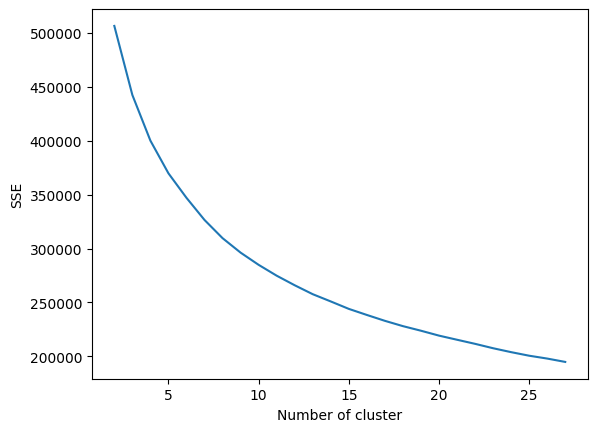

In [61]:
plt.figure()
plt.plot(kmeans_metrics["k"], kmeans_metrics["sse (inertia)"])
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

In [60]:
kmeans_metrics.to_excel("kmeans_metrics.xlsx")

In [ ]:

for k in range(1, 27):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(df_ED)
    # data["clusters"] = 
    sse[k] = kmeans.inertia_

In [51]:
silhouette_score(df_ED, kmeans.labels_)

NameError: name 'silhouette_score' is not defined

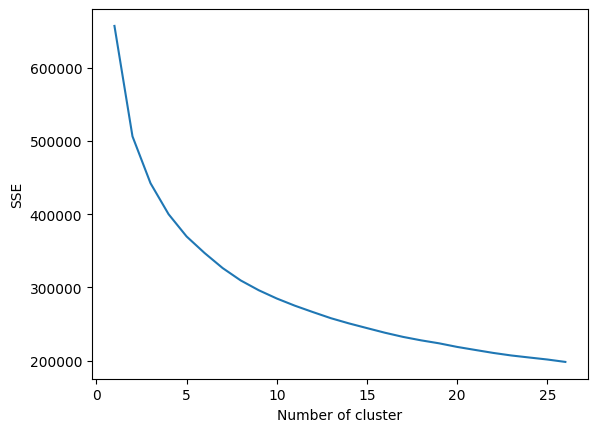

In [53]:
kmeans = KMeans(n_clusters=27)
kmeans.fit(pca_df)


KMeans(n_clusters=27)

## Final Clustering w. KMeans + PCA Visualization

In [179]:
df_ED.head()

type,EXT,EST,AGR,CSN,OPN
0,8.0,-3.0,4.5,1.0,7.5
3,-4.5,3.5,2.0,-3.5,2.5
4,2.0,2.5,8.0,-1.0,7.0
5,1.5,0.5,4.5,2.5,4.5
6,4.5,-4.0,-4.0,4.5,1.5


In [145]:
from sklearn.cluster import KMeans

In [156]:
kmeans_5 = KMeans(n_clusters=5, random_state=0).fit(df_ED)
kmeans_7 = KMeans(n_clusters=7, random_state=0).fit(df_ED)
kmeans_11 = KMeans(n_clusters=11, random_state=0).fit(df_ED)

In [188]:
pca_5 = PCA(n_components=2)
pca_5_fit = pca.fit_transform(df_ED)
df_pca_5 = pd.DataFrame(pca_5_fit, columns=["PC1", "PC2"])
df_pca_5["Cluster"] = kmeans_5.labels_

pca_7 = PCA(n_components=2)
pca_7_fit = pca.fit_transform(df_ED)
df_pca_7 = pd.DataFrame(pca_7_fit, columns=["PC1", "PC2"])
df_pca_7["Cluster"] = kmeans_7.labels_

pca_11 = PCA(n_components=2)
pca_11_fit = pca.fit_transform(df_ED)
df_pca_11 = pd.DataFrame(pca_11_fit, columns=["PC1", "PC2"])
df_pca_11["Cluster"] = kmeans_11.labels_

In [185]:
np.set_printoptions(suppress=True)

[[-2.273 -1.426  5.293  4.643  4.305]
 [-4.603  4.589  2.824  0.581  3.558]
 [ 3.336  3.076  5.074 -0.004  4.858]
 [-2.185 -2.139 -0.651  0.31   3.825]
 [ 4.778 -4.082  5.859  3.66   5.469]]


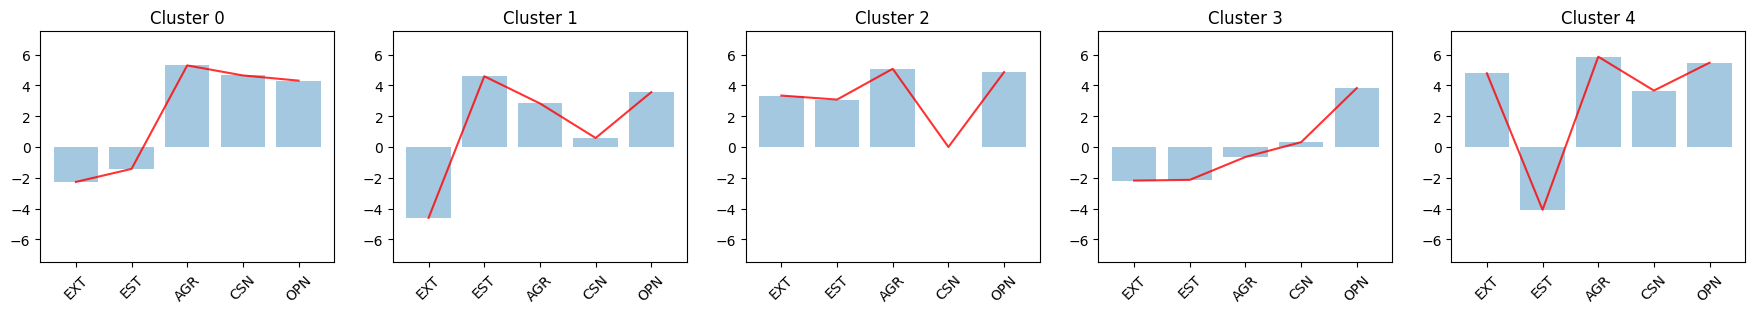

In [186]:
print(kmeans_5.cluster_centers_.round(3))
plt.figure(figsize=(22,3))
for i in range(5):
    
    plt.subplot(1,5,i+1)
    plt.title(f"Cluster {i}")
    plt.bar(df_ED.columns, kmeans_5.cluster_centers_[i], alpha=0.4)
    plt.plot(df_ED.columns, kmeans_5.cluster_centers_[i], color="red", alpha=0.8)
    plt.xticks(rotation=45)
    plt.ylim(-7.5, 7.5)

Text(0.5, 1.0, 'Personality Clusters after PCA')

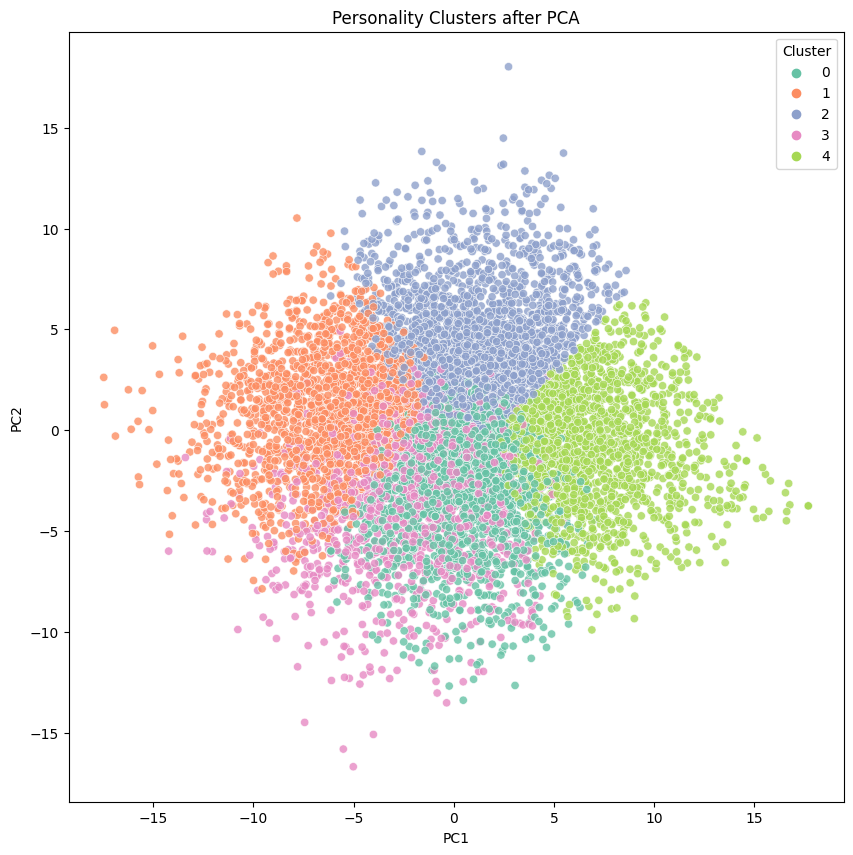

In [189]:
plt.figure(figsize=(10,10))
sns.scatterplot(data=df_pca_5, x='PC1', y='PC2', hue='Cluster', palette='Set2', alpha=0.8)
plt.title('Personality Clusters after PCA')

[[ 4.09   3.709  5.469  0.41   5.652]
 [-0.412  0.923  3.205  1.276  0.261]
 [-3.153 -3.323  3.582  4.252  5.223]
 [ 4.357 -3.534  6.556  5.519  5.281]
 [ 3.317 -3.351  3.242 -1.387  5.589]
 [-5.282  2.303 -1.847  0.126  4.05 ]
 [-3.868  4.538  5.2    1.395  4.909]]


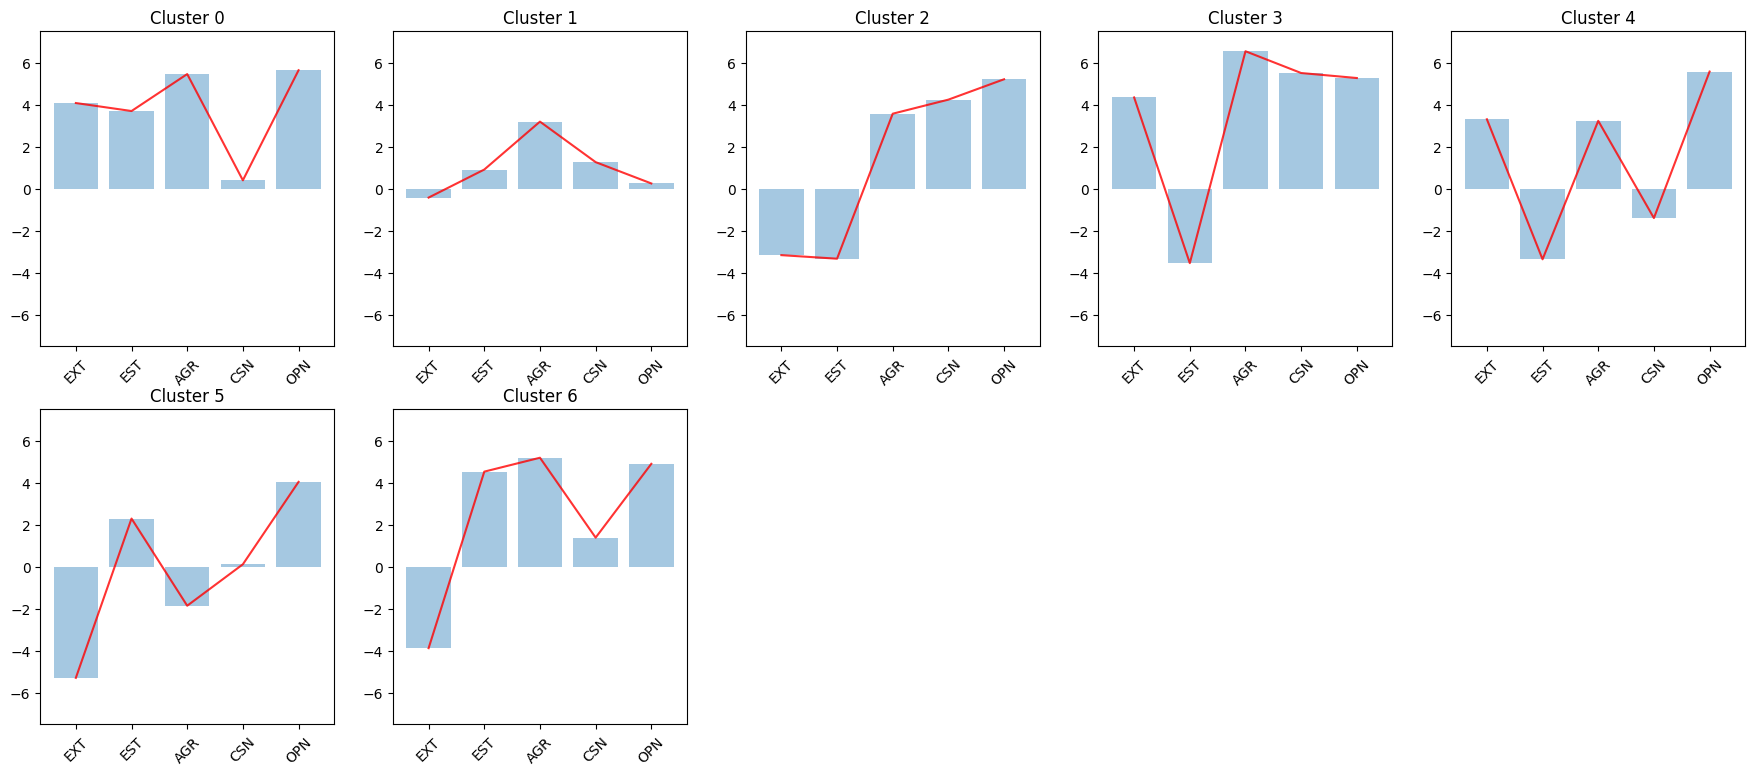

In [196]:
print(kmeans_7.cluster_centers_.round(3))
plt.figure(figsize=(22,9))
for i in range(7):
    
    plt.subplot(2,5,i+1)
    plt.title(f"Cluster {i}")
    plt.bar(df_ED.columns, kmeans_7.cluster_centers_[i], alpha=0.4)
    plt.plot(df_ED.columns, kmeans_7.cluster_centers_[i], color="red", alpha=0.8)
    plt.xticks(rotation=45)
    plt.ylim(-7.5, 7.5)

Text(0.5, 1.0, 'Personality Clusters after PCA')

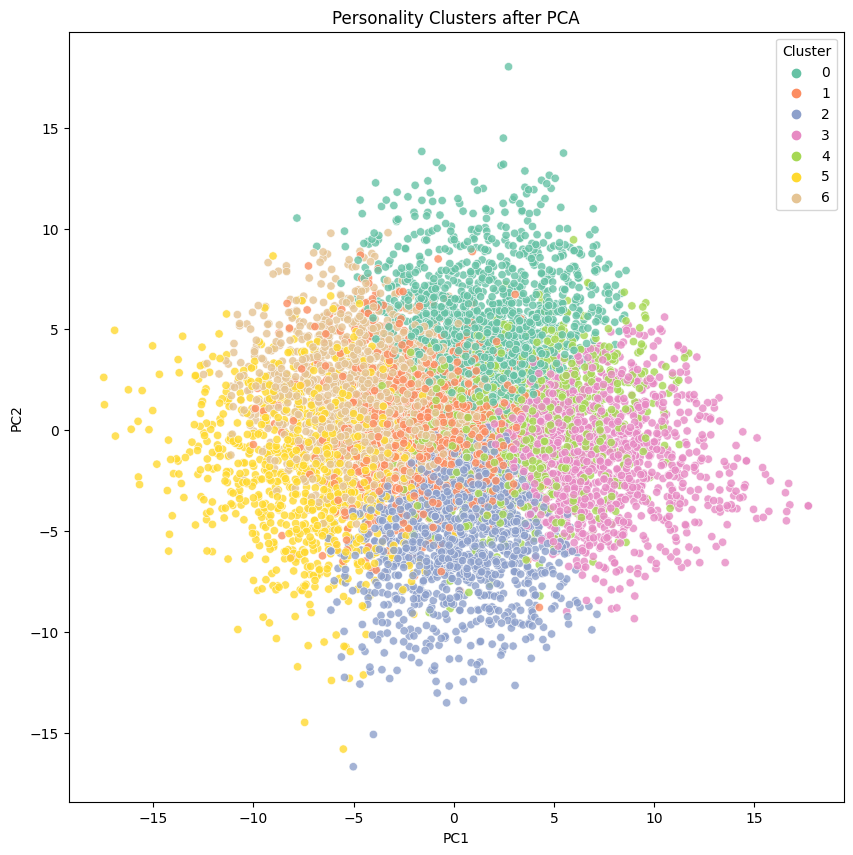

In [197]:
plt.figure(figsize=(10,10))
sns.scatterplot(data=df_pca_7, x='PC1', y='PC2', hue='Cluster', palette='Set2', alpha=0.8)
plt.title('Personality Clusters after PCA')

[[ 5.224  3.673  5.356 -1.35   5.165]
 [-4.865  4.188  5.315  4.059  4.128]
 [ 2.576  2.137  6.017  4.813  5.477]
 [-2.192  4.092  4.708 -1.784  5.746]
 [ 4.964 -4.899  6.585  5.634  5.518]
 [ 0.581  0.226  2.932  1.503  0.439]
 [-3.858  3.49  -2.373  2.152  6.28 ]
 [-2.901 -4.329 -1.595  1.249  5.442]
 [-5.721  3.055  0.996 -0.908  0.386]
 [-2.998 -3.577  5.21   4.291  4.994]
 [ 4.092 -3.388  4.407 -1.092  5.72 ]]


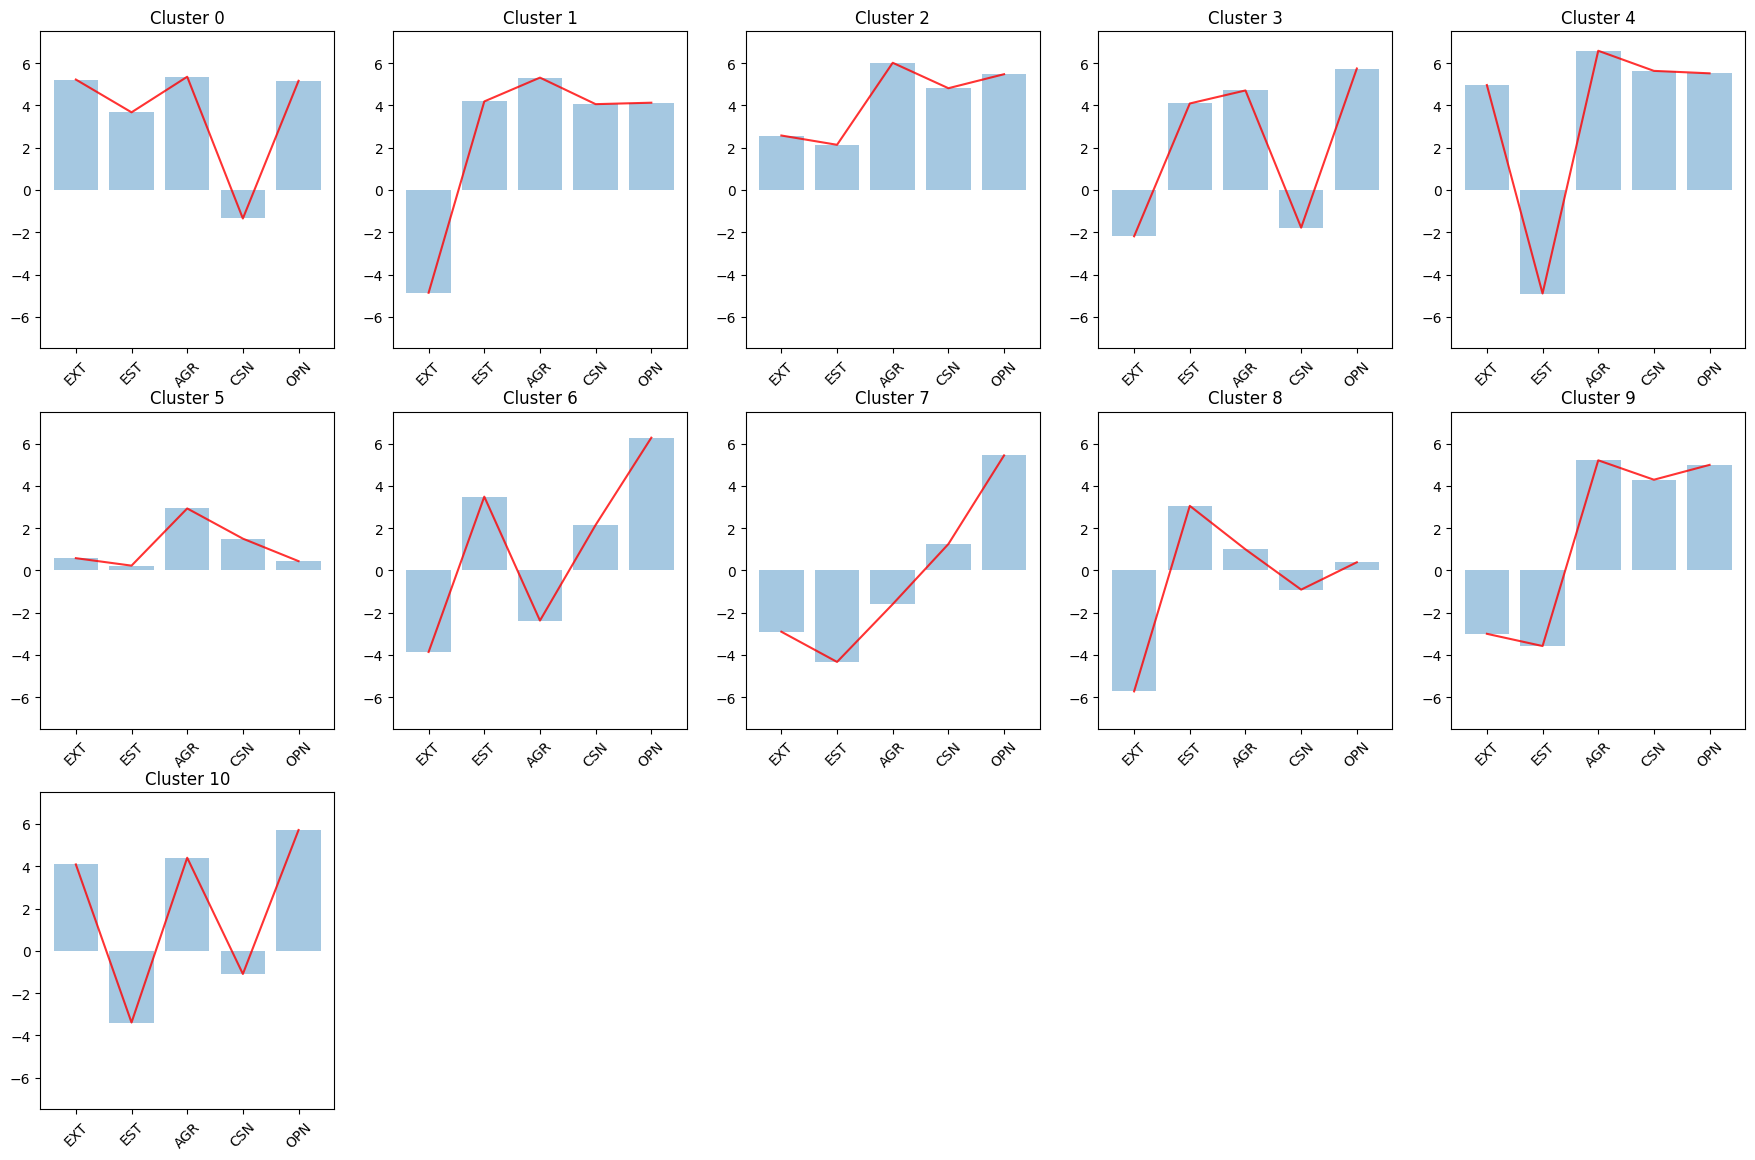

In [198]:
print(kmeans_11.cluster_centers_.round(3))
plt.figure(figsize=(22,14))
for i in range(11):
    
    plt.subplot(3,5,i+1)
    plt.title(f"Cluster {i}")
    plt.bar(df_ED.columns, kmeans_11.cluster_centers_[i], alpha=0.4)
    plt.plot(df_ED.columns, kmeans_11.cluster_centers_[i], color="red", alpha=0.8)
    plt.xticks(rotation=45)
    plt.ylim(-7.5, 7.5)

Text(0.5, 1.0, 'Personality Clusters after PCA')

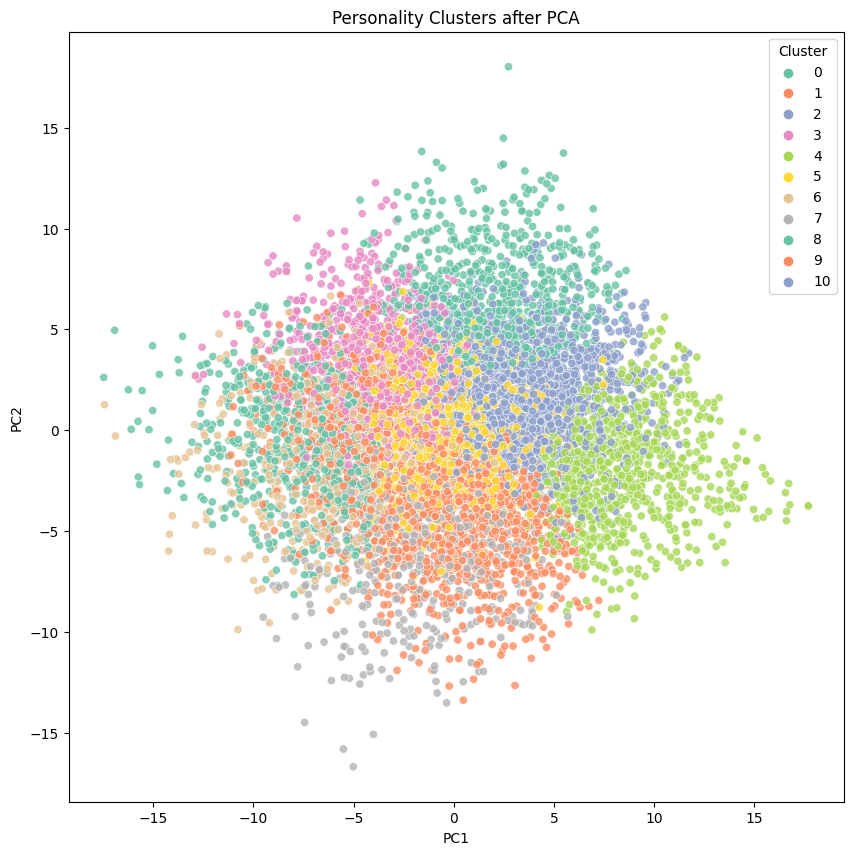

In [199]:
plt.figure(figsize=(10,10))
sns.scatterplot(data=df_pca_11, x='PC1', y='PC2', hue='Cluster', palette='Set2', alpha=0.8)
plt.title('Personality Clusters after PCA')

In [ ]:
plt.figure(figsize=(22,3))
for i in range(5):
    
    plt.subplot(1,5,i+1)
    plt.title(f"Cluster {i}")
    plt.bar(df_ED.columns, kmeans_5.cluster_centers_[i], alpha=0.4)
    plt.plot(df_ED.columns, kmeans_5.cluster_centers_[i], color="red", alpha=0.8)
    plt.xticks(rotation=45)
    plt.ylim(-7.5, 7.5)

In [ ]:
# Visualizing the means for each cluster
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.bar(dataclusters.columns, dataclusters.iloc[:, i], color='green', alpha=0.2)
    plt.plot(dataclusters.columns, dataclusters.iloc[:, i], color='red')
    plt.title('Cluster ' + str(i))
    plt.xticks(rotation=45)
    plt.ylim(0,4)

In [158]:
from sklearn.decomposition import PCA

pca_5 = PCA(n_components=2)
pca_5_fit = pca.fit_transform(df_ED)
df_pca_5 = pd.DataFrame(pca_5_fit, columns=["PC1", "PC2"])
df_pca_5["Cluster"] = kmeans_5.labels_

pca_7 = PCA(n_components=2)
pca_7_fit = pca.fit_transform(df_ED)
df_pca_7 = pd.DataFrame(pca_7_fit, columns=["PC1", "PC2"])
df_pca_7["Cluster"] = kmeans_7.labels_

pca_11 = PCA(n_components=2)
pca_11_fit = pca.fit_transform(df_ED)
df_pca_11 = pd.DataFrame(pca_11_fit, columns=["PC1", "PC2"])
df_pca_11["Cluster"] = kmeans_11.labels_

In [150]:
import seaborn as sns

Text(0.5, 1.0, 'Personality Clusters after PCA')

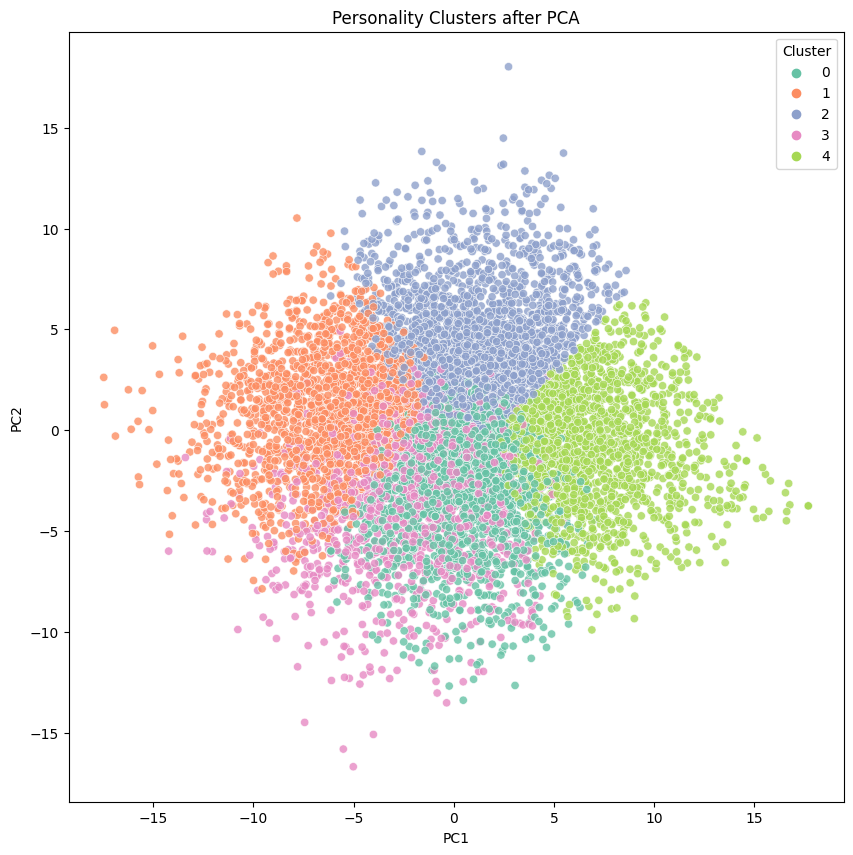

In [159]:
plt.figure(figsize=(10,10))
sns.scatterplot(data=df_pca_5, x='PC1', y='PC2', hue='Cluster', palette='Set2', alpha=0.8)
plt.title('Personality Clusters after PCA')

array([[ 4.09044636,  3.70947533,  5.46945967,  0.41033673,  5.65191856],
       [-0.41236307,  0.92331768,  3.20461659,  1.2758216 ,  0.26134585],
       [-3.15312966, -3.32265276,  3.58196721,  4.25223547,  5.22280179],
       [ 4.35725369, -3.53374709,  6.55624515,  5.51939488,  5.28122576],
       [ 3.31711066, -3.35092213,  3.24180328, -1.38678279,  5.58862705],
       [-5.28160329,  2.30267215, -1.84737924,  0.12589928,  4.04984584],
       [-3.86832987,  4.53776854,  5.1999307 ,  1.3950104 ,  4.90921691]])

In [154]:

pca_df["KMEANS_Cluster"] = kmeans.labels_
fig = px.scatter_3d(pca_df, x='PC1', y='PC2', z="PC3", color='KMEANS_Cluster')
fig.show()

ValueError: Length of values (1000) does not match length of index (8578)

In [22]:
pca_df["KMEANS_Cluster"].value_counts().sort_index()

0     640
1     483
2     443
3     535
4     494
5     403
6     229
7     316
8     417
9     248
10    316
11    327
12    190
13    321
14    513
15    489
16    301
17    314
18    418
19    317
20    226
21    345
22    524
23    305
24    278
25    175
26    385
Name: KMEANS_Cluster, dtype: int64

In [23]:
pca_df.dtypes

PC1               float64
PC2               float64
PC3               float64
KMEANS_Cluster      int32
dtype: object

In [27]:
fig = go.Figure()

for index in range(27):
    subset = pca_df[pca_df["KMEANS_Cluster"] == index]
    fig.add_trace(
        go.Scatter3d(
            x=subset["PC1"],
            y=subset["PC2"],
            z=subset["PC3"],
            mode="markers",
            name=f"Cluster {index}",
        ),
    )

buttons_list = []
for index in range(27):
    buttons_list.append(
        dict(
            label=f"Show Cluster {index}",
            method="update",
            args=[
                {"visible": [False] * index + [True] + [False] * (26 - index)},
                {"title": f"Cluster {index}"},
            ],
        )
    )

buttons_list.append(
    dict(
        label="Show All Clusters",
        method="update",
        args=[{"visible": [True] * 27}, {"title": "All Clusters"}],
    )
)

fig.update_layout(updatemenus=[dict(buttons=buttons_list)])
fig.update_scenes(
    xaxis_title="PC1",
    xaxis_range=[-5, 5],
    xaxis_autorange=False,
    yaxis_title="PC2",
    yaxis_range=[-5, 5],
    yaxis_autorange=False,
    zaxis_title="PC3",
    zaxis_range=[-5, 5],
    zaxis_autorange=False,
)

fig.update_xaxes(range=[-5, 5])
fig.update_yaxes(range=[-5, 5])
fig.show()

In [28]:
fig.write_html("pca-clustering.html")

## MISC

In [203]:
pcaf = PCA(n_components=2)
pcaf = pcaf.fit(df_ED)

kmeans5loc = pcaf.transform(kmeans_5.cluster_centers_)
kmeans7loc = pcaf.transform(kmeans_7.cluster_centers_)
kmeans11loc = pcaf.transform(kmeans_11.cluster_centers_)

/Users/elim-mbp-01/.pyenv/versions/3.8.16/envs/dsc80_39/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning:

X does not have valid feature names, but PCA was fitted with feature names

/Users/elim-mbp-01/.pyenv/versions/3.8.16/envs/dsc80_39/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning:

X does not have valid feature names, but PCA was fitted with feature names

/Users/elim-mbp-01/.pyenv/versions/3.8.16/envs/dsc80_39/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning:

X does not have valid feature names, but PCA was fitted with feature names



In [214]:
kmeans5loc

array([[ 0.48359862, -3.0185661 ],
       [-6.24776385,  1.07945378],
       [ 1.17826031,  4.82702869],
       [-2.27657187, -3.38195558],
       [ 7.14121833, -0.83612537]])

In [207]:
type(kmeans5loc)

numpy.ndarray

Text(0.5, 1.0, 'Cluster Centroids Through Increasing Cluster Count')

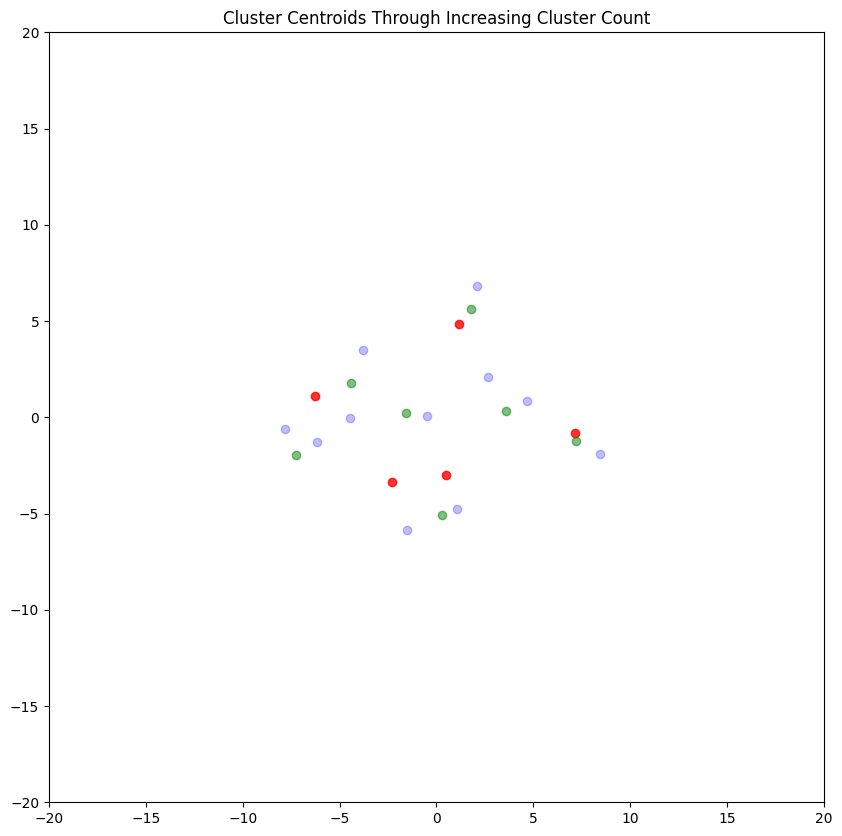

In [227]:
plt.figure(figsize=(10,10))
plt.scatter(kmeans5loc[:, 0], kmeans5loc[:, 1], c="red", alpha=0.8)
plt.scatter(kmeans7loc[:, 0], kmeans7loc[:, 1], c="green", alpha=0.5)
plt.scatter(kmeans11loc[:, 0], kmeans11loc[:, 1], c="blue", alpha=0.25)
# plt.scatterplot(x=kmeans5loc[:, 0], y=kmeans5loc[:, 1], hue="A", palette='Set2', alpha=0.8)
# sns.scatterplot(x=kmeans5loc[:, 0], y=kmeans5loc[:, 1], palette='Set2', alpha=0.8)
plt.ylim(-20, 20)
plt.xlim(-20, 20)
plt.title('Cluster Centroids Through Increasing Cluster Count')